# Вебинар 5. Обучение без учителя.

1. Кластеризация - разделение данных на группы
2. Понижение размерности - из N фичей сделать 2 или 3, и визуализировать

**Подключение библиотек и скриптов**

In [1]:
import numpy as np
import pandas as pd
import pickle

from scipy.spatial.distance import cdist
from mpl_toolkits.mplot3d.axes3d import Axes3D

from sklearn.preprocessing import StandardScaler, RobustScaler

# клакстеризация
from sklearn.cluster import KMeans

# Понижения размерности
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score as r2, mean_absolute_error as mae, mean_squared_error as mse

from lightgbm import LGBMRegressor

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/Users/igor/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
matplotlib.rcParams.update({'font.size': 12})

In [3]:
def reduce_dims(df, dims=2, method='pca'):
    
    assert method in ['pca', 'tsne'], 'Неверно указан метод'
    
    if method=='pca':
        dim_reducer = PCA(n_components=dims, random_state=42)
        components = dim_reducer.fit_transform(df)
    elif method == 'tsne':
        dim_reducer = TSNE(n_components=dims, learning_rate=250, random_state=42)
        components = dim_reducer.fit_transform(df)
    else:
        print('Error')
        
    colnames = ['component_' + str(i) for i in range(1, dims+1)]
    return dim_reducer, pd.DataFrame(data = components, columns = colnames) 

In [4]:
def display_components_in_2D_space(components_df, labels=None):
    components_with_labels_df = pd.concat([components_df, labels], axis=1)

    if labels is not None:
        components_with_labels_df.plot(kind='scatter', x='component_1', y='component_2', 
                                         c=components_with_labels_df.iloc[:, -1], cmap=plt.get_cmap('jet'),
                                         alpha=0.5, figsize=(15,10))
    else:
        components_with_labels_df.plot(kind='scatter', x='component_1', y='component_2', alpha=0.5, figsize=(15,10))

    plt.xlabel('component_1')
    plt.ylabel('component_2')
    plt.title('2D mapping of objects')    
    plt.show()

def display_components_in_3D_space(components_df, labels=None):
    components_with_labels_df = pd.concat([components_df, labels], axis=1)

    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(111, projection='3d')
    
    if labels is not None:
        ax.scatter(components_with_labels_df['component_1'], 
                   components_with_labels_df['component_2'], 
                   components_with_labels_df['component_3'], 
                   c=components_with_labels_df.iloc[:, -1], 
                   cmap=plt.get_cmap('jet'), alpha=0.5)
    else:
        ax.scatter(components_with_labels_df['component_1'], 
                   components_with_labels_df['component_2'], 
                   components_with_labels_df['component_3'], 
                   alpha=0.5)

    ax.set_xlabel('component_1')
    ax.set_ylabel('component_2')
    ax.set_zlabel('component_3')
    plt.title('3D mapping of objects')
    plt.show()

In [5]:
def apply_elbow_method(X):
    """Визуализация для метода 'локтя'"""
    
    distortions = []
    K = range(2,15)
    for k in K:
        kmeanModel = KMeans(n_clusters=k, random_state=33).fit(X)
        distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

    plt.figure(figsize=(10, 8))
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()

In [6]:
def display_clusters_distribution(unique_labels, labels_counts):
    """Визуализация распределения классов по кластерам"""
    plt.figure(figsize=(8,5))

    plt.bar(unique, counts)

    plt.xlabel('Clгsters')
    plt.xticks(unique)
    plt.ylabel('Count')
    plt.title('Clusters distribution')
    plt.show()

In [7]:
def evaluate_preds(true_values, pred_values):
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "MAE:\t" + str(round(mae(true_values, pred_values), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3)))
    
    plt.figure(figsize=(10,10))
    
    sns.scatterplot(x=pred_values, y=true_values)
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    plt.show()

**Пути к директориям и файлам**

In [8]:
TRAIN_DATASET_PATH = './housing_prepared.csv'
TRAIN_DATASET_EXT_PATH = './housing_train_ext.csv'

### Загрузка данных

**Описание датасета**

Статистические данные о ряде домов в Калифорнии, основанные на переписи 1990 года.

* **longitude** - долгота
* **latitude** - широта
* **housing_median_age** - средний возраст дома
* **total_rooms** - общее количество комнат
* **total_bedrooms** - общее количество спален
* **population** - количество проживающих
* **households** - домохозяйства
* **ocean_proximity** - близость океана
* **median_income** - средний доход
* **median_house_value** - средняя стоимость дома

In [9]:
df = pd.read_csv(TRAIN_DATASET_PATH)
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,<1H OCEAN,INLAND,NEAR BAY,NEAR OCEAN,median_house_value
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,0,0,1,0,452600.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,0,0,1,0,358500.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,0,0,1,0,352100.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,0,0,1,0,341300.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,0,0,1,0,342200.0


In [10]:
df.dtypes

longitude             float64
latitude              float64
housing_median_age    float64
total_rooms           float64
total_bedrooms        float64
population            float64
households            float64
median_income         float64
<1H OCEAN               int64
INLAND                  int64
NEAR BAY                int64
NEAR OCEAN              int64
median_house_value    float64
dtype: object

### Определение признакового пространства

In [11]:
X = df.drop('median_house_value', axis=1)
y = df[['median_house_value']]

X.head(2)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,<1H OCEAN,INLAND,NEAR BAY,NEAR OCEAN
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,0,0,1,0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,0,0,1,0


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=42)

## Масштабирование / Нормализация !!!

In [13]:
# Для каждой фичи х делает: (x - mean) / std
# scaler = StandardScaler()

# Для каждой фичи х делает: (x - median) / (q75 - q25)
## (q75 - q25) похоже на std
## median на mean
## НО median, q75, q25 устойчивы к выбросам
scaler = RobustScaler(with_centering=True, with_scaling=True, quantile_range=(25.0, 75.0))

colnames = X.columns
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=colnames)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=colnames) # НЕ обучаемся на тесте!

X_train_scaled.head(2)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,<1H OCEAN,INLAND,NEAR BAY,NEAR OCEAN
0,0.058201,-0.047493,0.277778,-1.003827,-0.840000,-0.740781,-0.847095,-0.887348,1.0,0.0,0.0,0.0
1,0.142857,-0.039578,0.444444,-0.315573,-0.182857,0.000000,-0.186544,-0.241859,0.0,1.0,0.0,0.0


В _scaled все признаки измеряются в одних единицах

In [14]:
X_train_scaled.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,<1H OCEAN,INLAND,NEAR BAY,NEAR OCEAN
count,13182.000000,13182.000000,13182.000000,13182.000000,13182.000000,13182.000000,13182.000000,13182.000000,13182.000000,13182.000000,13182.000000,13182.000000
mean,-0.276562,0.364537,-0.027660,0.300967,0.292786,0.290710,0.273466,0.104160,0.435366,0.329768,0.109316,0.125322
std,0.531098,0.566246,0.682095,1.272357,1.198075,1.242256,1.169150,0.754593,0.495824,0.470147,0.312047,0.331097
min,-1.539683,-0.459103,-1.555556,-1.237563,-1.237143,-1.260304,-1.250765,-1.431143,0.000000,0.000000,0.000000,0.000000
25%,-0.859788,-0.092348,-0.611111,-0.390344,-0.391429,-0.389371,-0.397554,-0.453643,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.140212,0.907652,0.388889,0.609656,0.608571,0.610629,0.602446,0.546357,1.000000,1.000000,0.000000,0.000000
max,1.116402,2.023747,1.277778,17.970562,17.171429,37.437093,17.342508,5.577254,1.000000,1.000000,1.000000,1.000000


Когда **необходимо** применять масштабирование/нормализацию:
- Во всех методах понижения размерности
- В линейной регрессии

Когда **не обязательно** использовать масштабирование/нормализацию:
- Дерево решений
- Случайный лес
- Градентный бустинг

### Понижение размерности: PCA -  Principal Component Analysis (метод главных компонент)

**Из 2-мерного пространства в 1-мерное**

фичи X1, X2

$$component_1 = a_1*X_1 + a_2*X_2$$

/Users/igor/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


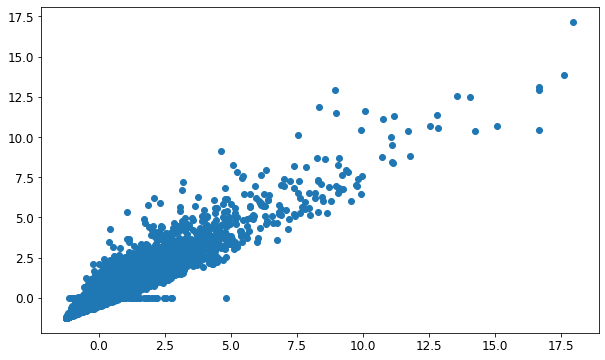

In [15]:
X_small = X_train_scaled[['total_rooms', 'total_bedrooms']]

pca = PCA(n_components=1, random_state=42)
X_small['component_1'] = pca.fit_transform(X_small)

plt.figure(figsize=(10,6))
plt.scatter(X_small.total_rooms,  X_small.total_bedrooms)
plt.show()

PCA подбирает такую линию, вдоль которой ледат точкп

В линейной регресии вы минимизируете "вертикальную разницу":
    $$\sum(y - y_{hat})^2$$
    
В PCA вы минмизируете среднее расстояние от точек до линии - перпендикуляр к линиии:
$$\sum (x1_{i} - x1'_{i})^2 + (x2_{i} - x2'_{i})^2$$

**Как работает PCA из 3d в 2d**

<img src="pca_1.png">

**Снижение размерности до 2х компонент**

In [16]:
dim_reducer2d, components_2d = reduce_dims(X_train_scaled, dims=2, method='pca')
components_2d.head(2)

,component_1,component_2
0,-2.325676,0.300858
1,-0.968829,-0.096801


In [17]:
X_train_scaled.shape, components_2d.shape

((13182, 12), (13182, 2))

In [18]:
dim_reducer2d

PCA(copy=True, iterated_power='auto', n_components=2, random_state=42,
    svd_solver='auto', tol=0.0, whiten=False)

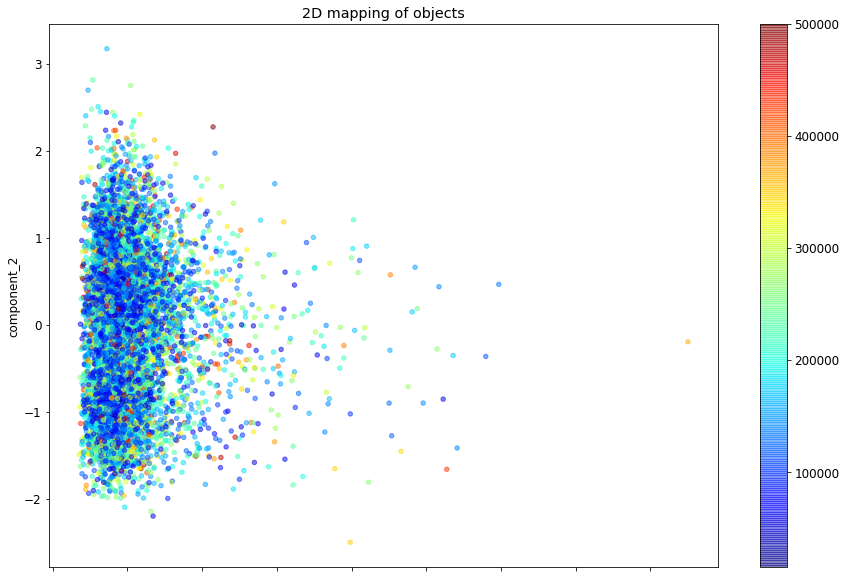

In [19]:
display_components_in_2D_space(components_2d, y_train)

**Снижение размерности до 3х компонент**

In [20]:
dim_reducer3d, components_3d = reduce_dims(X_train_scaled, dims=3, method='pca')

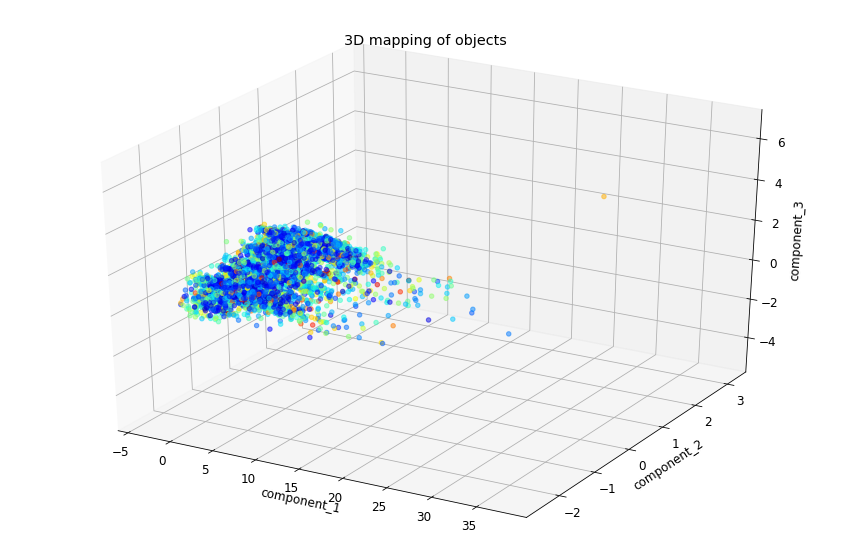

In [21]:
display_components_in_3D_space(components_3d, y_train)

## TSNE

Объяснение можно посмотреть [здесь](https://mlexplained.com/2018/09/14/paper-dissected-visualizing-data-using-t-sne-explained/)

# Кластеризация

Алгоритмы:
- K-means: объяснен в вебинаре (ниже)
- [Иерархическая кластеризация](https://towardsdatascience.com/https-towardsdatascience-com-hierarchical-clustering-6f3c98c9d0ca)
- [HDBScan](https://towardsdatascience.com/lightning-talk-clustering-with-hdbscan-d47b83d1b03a)

### Кластеризация: k-means

**Как работает k-means**

Вы указываете кол-во кластеров

1. Центры кластеров случайно инициализируются
2. От каждой точки рассчитывается расстояние до центра каждого кластера
3. Присваиваем каждую точку к тому кластру, к центру которого она ближе
4. Пересчитываем центры кластеров: берем среднее по всем фичам --> новый центр кластера
    
итеративно повторяем шаги 2-4. Пока центры кластеров не перестанут "двигаться"

Хорошо работает, когда кластеры "шарообразные"

<img src="kmeans_v1.gif">

<img src="kmeans_v2.gif">

**Выделение 3 кластеров**

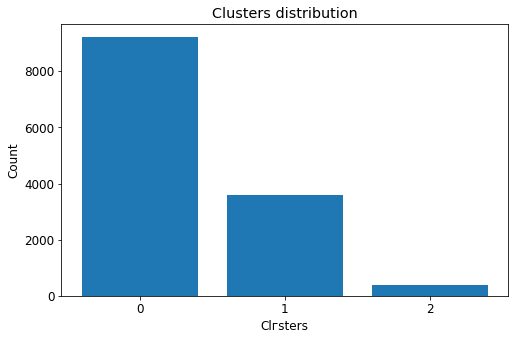

In [22]:
kmeans_3 = KMeans(n_clusters=3, random_state=42)
labels_clast_3 = kmeans_3.fit_predict(X_train_scaled)
labels_clast_3 = pd.Series(labels_clast_3, name='clusters_3')

unique, counts = np.unique(labels_clast_3, return_counts=True)
display_clusters_distribution(unique, counts)

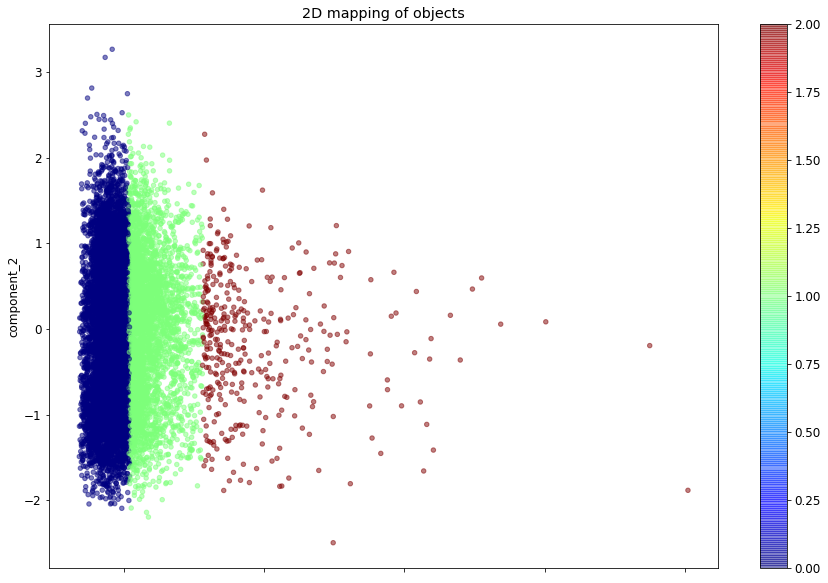

In [23]:
display_components_in_2D_space(components_2d, labels_clast_3)

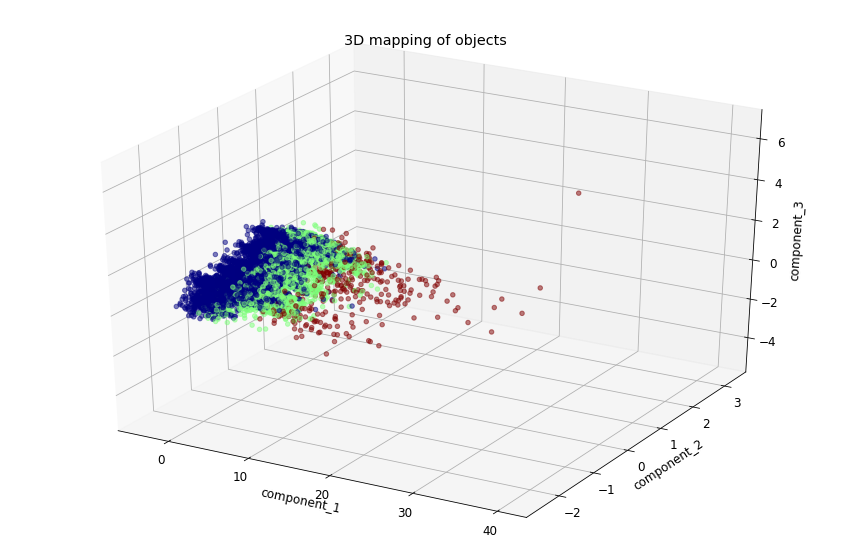

In [24]:
display_components_in_3D_space(components_3d, labels_clast_3)

**Выделение 10 кластеров**

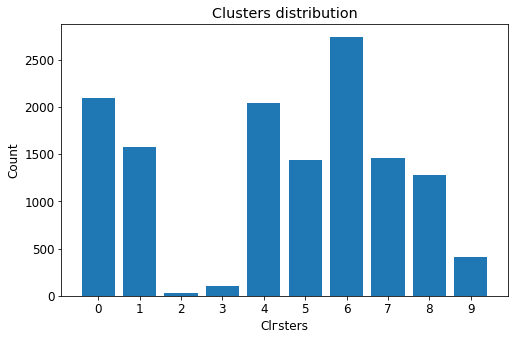

In [25]:
kmeans_10 = KMeans(n_clusters=10, random_state=42)
labels_clast_10 = kmeans_10.fit_predict(X_train_scaled)
labels_clast_10 = pd.Series(labels_clast_10, name='clusters_10')

unique, counts = np.unique(labels_clast_10, return_counts=True)
display_clusters_distribution(unique, counts)

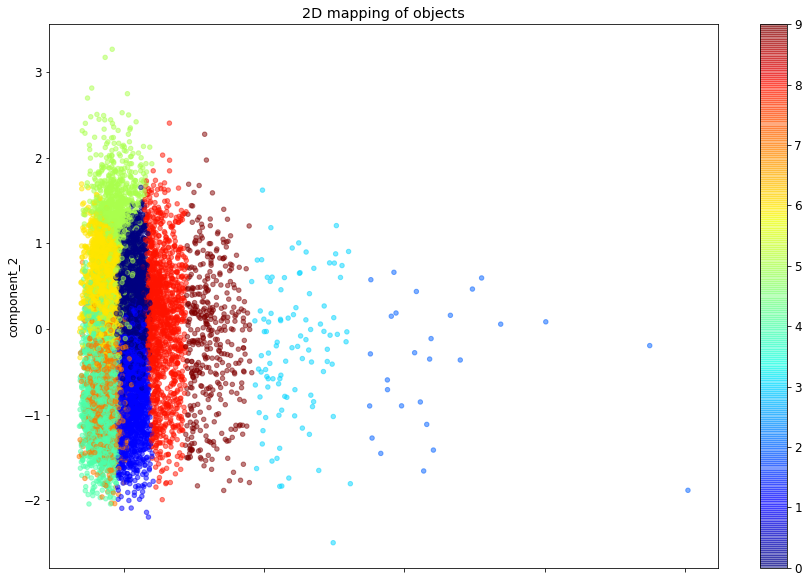

In [26]:
display_components_in_2D_space(components_2d, labels_clast_10)

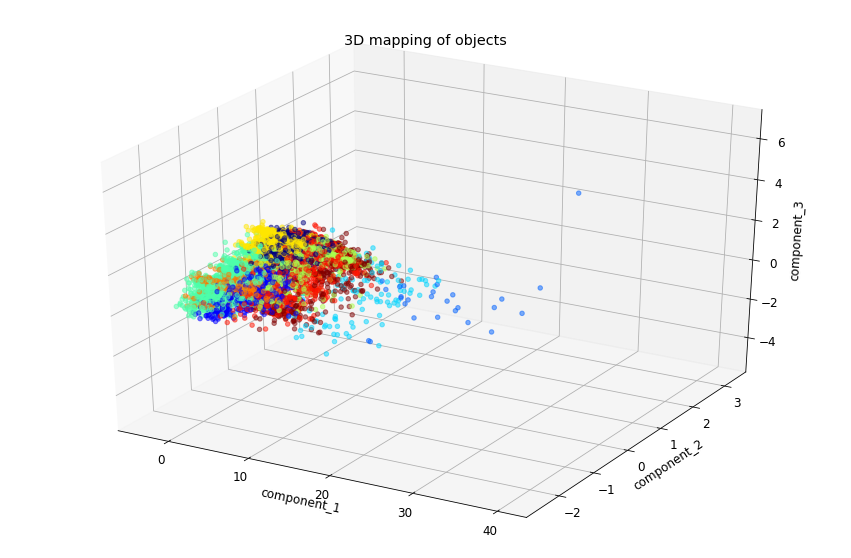

In [27]:
display_components_in_3D_space(components_3d, labels_clast_10)

### Оценка оптимального кол-ва кластеров

Дисперсия точек вокруг цетров кластеров

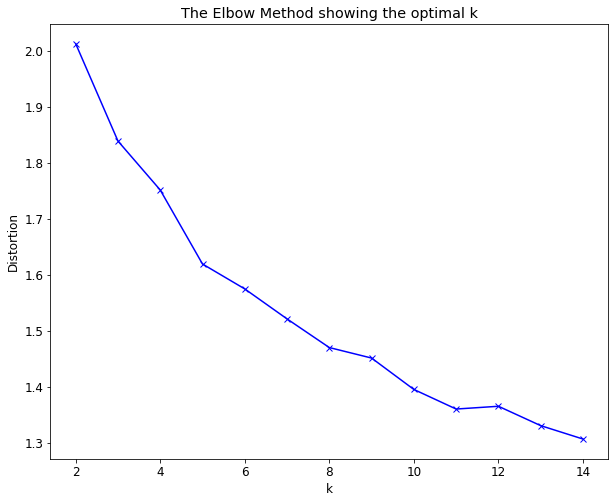

In [29]:
apply_elbow_method(X_train_scaled)

### Добавление новых признаков

In [23]:
clusters_3_dummies = pd.get_dummies(labels_clast_3, drop_first=True, prefix='clusters_3')
clusters_10_dummies = pd.get_dummies(labels_clast_10, drop_first=True, prefix='clusters_10')

X_train_scaled = pd.concat([X_train_scaled, components_3d, clusters_3_dummies, clusters_10_dummies, df['median_house_value']], 
                   axis=1)

X_train_scaled.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,<1H OCEAN,INLAND,...,clusters_10_1,clusters_10_2,clusters_10_3,clusters_10_4,clusters_10_5,clusters_10_6,clusters_10_7,clusters_10_8,clusters_10_9,median_house_value
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,0,0,...,0,0,1,0,0,0,0,0,0,452600.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,0,0,...,0,1,0,0,0,0,0,0,0,358500.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,0,0,...,0,0,1,0,0,0,0,0,0,352100.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,0,0,...,0,0,1,0,0,0,0,0,0,341300.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,0,0,...,0,0,0,0,0,1,0,0,0,342200.0


### Сохранение расширенного обучающего датасета

In [24]:
df_ext.to_csv(TRAIN_DATASET_EXT_PATH, index=False, encoding='utf-8')

### Переобучение и оценка финальной модели

In [28]:
final_model = LGBMRegressor(criterion='mse',
                            max_depth=10,
                            min_samples_leaf=10,
                            random_state=42,  

                            n_estimators=400)
final_model.fit(X_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              criterion='mse', importance_type='split', learning_rate=0.1,
              max_depth=10, min_child_samples=20, min_child_weight=0.001,
              min_samples_leaf=10, min_split_gain=0.0, n_estimators=400,
              n_jobs=-1, num_leaves=31, objective=None, random_state=42,
              reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

R2:	0.936
MAE:	17478.44
MSE:	613623906.501


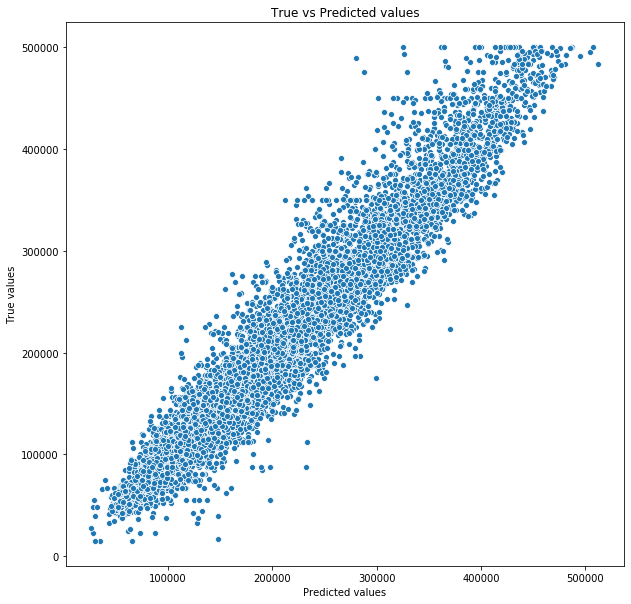

In [29]:
y_train_preds = final_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.824
MAE:	27873.349
MSE:	1692293486.922


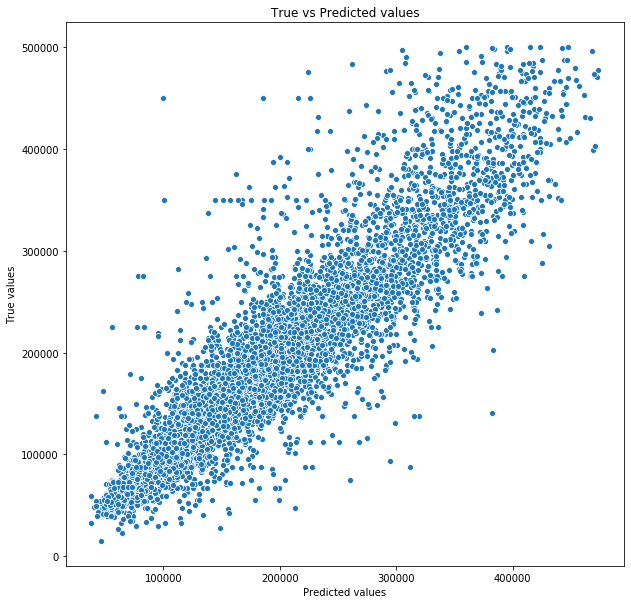

In [30]:
y_test_preds = final_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

*Без фичей с кластерами было 0.814 - см вебинар 4*

In [31]:
feature_importances = pd.DataFrame(zip(X_train.columns, final_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
1,latitude,1839
0,longitude,1784
7,median_income,1389
14,component_3,1277
13,component_2,1240
2,housing_median_age,957
5,population,780
6,households,673
3,total_rooms,563
4,total_bedrooms,552
